In [62]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.constants import G
from scipy import interpolate
from scipy.integrate import simps
from matplotlib import colors 
import tqdm
import warnings
import sys
sys.path.append('../my_funcs/')
from pipeline_main import pipeline
from pipeline_stress import _fill_2Dhist

# Set som plotting standards:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 16}
mpl.rc('font', **font)

In [96]:
def massflux(self, radius = 90, Nh = 100, N_phi = 200, refine_grid = 2, shell_Δ = 1, plot = True, verbose = 1):
    Nr = int(2 * Nh); N_phi_v = N_phi // 2; height = radius
    
    radius /= self.au_length; height /= self.au_length; shell_Δ /= self.au_length
    selection_radius = np.sqrt(radius**2 + height**2) * 2

    pp = [p for p in self.sn.patches if np.linalg.norm(p.rel_ppos, axis = 0) < selection_radius]
    w= np.array([p.level for p in pp]).argsort()[::-1]
    sorted_patches = [pp[w[i]] for i in range(len(pp))]

    if verbose != 0: print(f'Using {len(sorted_patches)} patches to retrive angular momentum change')


    #__________________________________________________EXTRACTING KNOWLEDGE OF THE RADIAL PART OF THE MASS FLUX___________________________________________________


    extracted_values =  {key: [] for key in range(5)}
    if verbose != 0: print('Calculating radial part')
    for p in sorted_patches:
        nbors = [self.sn.patchid[i] for i in p.nbor_ids if i in self.sn.patchid]
        children = [ n for n in nbors if n.level == p.level + 1]
        leafs = [n for n in children if ((n.position - p.position)**2).sum() < ((p.size)**2).sum()/12]   
        if len(leafs) == 8: continue

        to_extract = (p.cyl_R > radius - shell_Δ) & (p.cyl_R <  radius + shell_Δ)
        p.vφ = np.sum(p.vrel * p.e_φ, axis = 0)
        p.vr = np.sum(p.vrel * p.e_r, axis = 0)

        for lp in leafs: 
            leaf_extent = np.vstack((lp.position - 0.5 * lp.size, lp.position + 0.5 * lp.size)).T
            covered_bool = ~np.all((p.xyz > leaf_extent[:, 0, None, None, None]) & (p.xyz < leaf_extent[:, 1, None, None, None]), axis=0)
            to_extract *= covered_bool
         
        z_coor = p.cyl_z[to_extract].T 
        φ_coor = p.φ[to_extract].T
        vel_r = p.vr[to_extract].T 
        mass_val = p.m[to_extract].T

        extracted_values[0].extend(z_coor.tolist())
        extracted_values[1].extend(φ_coor.tolist())
        extracted_values[2].extend(vel_r.tolist())
        extracted_values[3].extend(mass_val.tolist())
        extracted_values[4].extend(p.ds[0]**3 * np.ones(len(mass_val)))
    
    for key in extracted_values:
        extracted_values[key] = np.array(extracted_values[key])
    
    #Making grid in height and phi direction:
    z_grid = np.linspace(-height, height, Nh); phi_grid = np.linspace(0, 2 * np.pi, N_phi)

    #Binning values
    hist_mass, binedges_phi, binedges_z = np.histogram2d(extracted_values[1], extracted_values[0], bins = (phi_grid, z_grid), weights = extracted_values[3])
    hist_vol, _, _ =  np.histogram2d(extracted_values[1], extracted_values[0], bins = (phi_grid, z_grid), weights = extracted_values[4])

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        hist_vr = np.histogram2d(extracted_values[1], extracted_values[0],  bins = (phi_grid, z_grid), weights = extracted_values[2] * extracted_values[3])[0] / hist_mass 
        hist_ρ = hist_mass/hist_vol
    
    if (hist_mass == 0).any and verbose != 0: print('Radial 2D histogram not completely covered')

    massflux_radial = - hist_vr * hist_ρ * self.cms_velocity * self.cgs_density 

    z_bins = z_grid[:-1] + 0.5 * np.diff(binedges_z)
    phi_bins = phi_grid[:-1] + 0.5 * np.diff(binedges_phi)

    znew_grid = np.linspace(-height, height, Nh * refine_grid); phinew_grid = np.linspace(0, 2 * np.pi, N_phi * refine_grid)

    massflux_Ir = self._fill_2Dhist(massflux_radial, orig_coor=[phi_bins, z_bins], new_coor=[phinew_grid, znew_grid], periodic_x=True)

    #__________________________________________________PLOTTING THE RADIAL PART OF THE STRESS_______________________________________________________

    tick_labels = ['$\pi$/3','2$\pi$/3','$\pi$', '4$\pi$/3', '5$\pi$/3', '2$\pi$']
    tick_values = [np.pi/3, 2*np.pi/3, np.pi, np.pi/3 + np.pi, 2*np.pi/3 + np.pi, 2*np.pi]

    if plot:
        fig, ax = plt.subplots(figsize = (14, 6))
        ax.set(ylabel = '[AU]', xlim = (0, 2*np.pi))
        ax.set_xticks(tick_values); ax.set_xticklabels(tick_labels)

        cs = ax.pcolormesh(phinew_grid, znew_grid * self.au_length, massflux_Ir.T, norm = colors.SymLogNorm(linthresh=1e-16, linscale=1, vmin = -1e-10, vmax = 1e-10), snap = True, shading = 'gouraud', cmap = 'coolwarm')
        cbar = fig.colorbar(cs, ax=ax, fraction = 0.2, pad = 0.06, location = 'top')
        cbar.set_label('Mass flux [g/cm$^2$/s]',fontsize = 18)

    #_______________________________________CALCULATING THE INTEGRAL (RADIAL) TO GET TOTAL ACCRETION RATE__________________________________________
    R = radius * self.sn.scaling.l

    Mdot_r = simps(simps(massflux_Ir * R, phinew_grid, axis = 0), znew_grid * self.sn.scaling.l)


    #__________________________________________EXTRACTING KNOWLEDGE OF THE VERTICAL PART OF THE MASS FLUX___________________________________________________


    #Looping over top and then bottom of the cylinder:
    for top in [1, 0]:
        extracted_values =  {key: [] for key in range(5)} # So far this is only for densities and velocities
        if verbose != 0: print('Calculating vertical part')
        for p in sorted_patches:
            nbors = [self.sn.patchid[i] for i in p.nbor_ids if i in self.sn.patchid]
            children = [ n for n in nbors if n.level == p.level + 1]
            leafs = [n for n in children if ((n.position - p.position)**2).sum() < ((p.size)**2).sum()/12]   
            if len(leafs) == 8: continue

            if top == True:
                to_extract = (p.cyl_z > height - shell_Δ) & (p.cyl_z <  height + shell_Δ)
            elif top == False:
                to_extract = (p.cyl_z > - height - shell_Δ) & (p.cyl_z < - height + shell_Δ)

            p.vz = np.sum(p.vrel * self.L[:,None, None, None], axis = 0)

            for lp in leafs: 
                leaf_extent = np.vstack((lp.position - 0.5 * lp.size, lp.position + 0.5 * lp.size)).T
                covered_bool = ~np.all((p.xyz > leaf_extent[:, 0, None, None, None]) & (p.xyz < leaf_extent[:, 1, None, None, None]), axis=0)
                to_extract *= covered_bool

            r_coor = p.cyl_R[to_extract].T
            φ_coor = p.φ[to_extract].T
            vel_z = p.vz[to_extract].T
            mass_val = p.m[to_extract].T

            extracted_values[0].extend(r_coor.tolist())
            extracted_values[1].extend(φ_coor.tolist())
            extracted_values[2].extend(vel_z.tolist())
            extracted_values[3].extend(mass_val.tolist())
            extracted_values[4].extend(p.ds[0]**3 * np.ones(len(mass_val)))
        
        for key in extracted_values:
            extracted_values[key] = np.array(extracted_values[key])

        #Making grid in height and phi direction:
        r_grid = np.logspace(np.log10(1e-3 / self.au_length), np.log10(radius), Nr); phi_grid = np.linspace(0, 2 * np.pi, N_phi_v)

        #Binning values
        hist_mass, binedges_phiv, binedges_r = np.histogram2d(extracted_values[1], extracted_values[0], bins = (phi_grid, r_grid), weights = extracted_values[3])
        hist_vol, _, _ =  np.histogram2d(extracted_values[1], extracted_values[0], bins = (phi_grid, r_grid), weights = extracted_values[4])
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            hist_vz = np.histogram2d(extracted_values[1], extracted_values[0],  bins = (phi_grid, r_grid), weights = extracted_values[2] * extracted_values[3])[0] / hist_mass 
            hist_ρ = hist_mass/hist_vol

        if (hist_mass == 0).any and top and verbose != 0: print('Vertical (top) 2D histogram not completely covered') 
        if (hist_mass == 0).any and top and verbose != 0: print('Vertical (bottom) 2D histogram not completely covered')

        if top == True:
            massflux_vertical = - hist_vz * hist_ρ * self.cms_velocity * self.cgs_density
        elif top == False:
            massflux_vertical = hist_vz * hist_ρ * self.cms_velocity * self.cgs_density


        r_bins = r_grid[:-1] + 0.5 * np.diff(binedges_r)
        phi_binsv = phi_grid[:-1] + 0.5 * np.diff(binedges_phiv)

        rnew_grid =np.logspace(np.log10(1e-3 / self.au_length), np.log10(radius), Nr * refine_grid); 
        phinew_gridv = np.linspace(0, 2 * np.pi, N_phi_v * refine_grid)

        if top == True:
            massflux_Iv = self._fill_2Dhist(massflux_vertical, orig_coor=[phi_binsv, r_bins], new_coor=[phinew_gridv, rnew_grid], periodic_x=True)
        elif top == False:
            massflux_Iv += self._fill_2Dhist(massflux_vertical, orig_coor=[phi_binsv, r_bins], new_coor=[phinew_gridv, rnew_grid], periodic_x=True)

    #__________________________________________________PLOTTING THE RADIAL PART OF THE STRESS_______________________________________________________
            
    if plot:
        fig, ax = plt.subplots(figsize = (10,10), subplot_kw={'projection' :'polar'})
        ax.set_xticks([]); ax.set_xticklabels([])
        ax.set_yticks([])

        cs = ax.pcolormesh(phinew_gridv, rnew_grid * self.au_length, massflux_Iv.T, norm = colors.SymLogNorm(linthresh=1e-16, linscale=1, vmin = -1e-10, vmax = 1e-10), snap = True, shading = 'gouraud', cmap = 'coolwarm')
        cbar = fig.colorbar(cs, ax=ax, fraction = 0.1, pad = 0.06)
        cbar.set_label('Mass flux [g/cm$^2$/s]',fontsize = 18)

    
    #___________________________________CALCULATING THE INTEGRAL (VERTICAL) TO GET TOTAL MASS ACCRETION__________________________________________
        
    r = rnew_grid * self.sn.scaling.l
    Mdot_v = simps(simps(massflux_Iv * r, phinew_gridv, axis = 0), r)

    if verbose != 0: print('Returns total accretion rate in radial and vertical direction resp.\nUnit: [g/s]')
    return np.array([Mdot_r, Mdot_v])

pipeline.massflux = massflux

In [11]:
data = pipeline(snap = 357, run = 'my_core_13lacc', sink_id=13)
data.recalc_L(verbose = 1); 
data.calc_disksize(plot = False); data.calc_trans_xyz() 

Initialising patch data


100%|██████████| 4165/4165 [00:03<00:00, 1243.70it/s]


Converged mean angular momentum vector after 0 iteration(s)
Looping through patches, assigning azimuthal velocities to all cells and extracing them within given cylindrical coordiantes


100%|██████████| 4165/4165 [00:00<00:00, 9066.71it/s] 


Disk size: 17.9 au
Transforming old z-coordinate into mean angular momentum vector


100%|██████████| 4165/4165 [00:00<00:00, 5109.54it/s]


Using 1376 patches to retrive angular momentum change
Calculating radial part
Radial 2D histogram not completely covered
Calculating vertical part
Vertical (top) 2D histogram not completely covered
Vertical (bottom) 2D histogram not completely covered
Calculating vertical part
Returns total accretion rate in radial and vertical direction resp.
 Unit: [g/s]


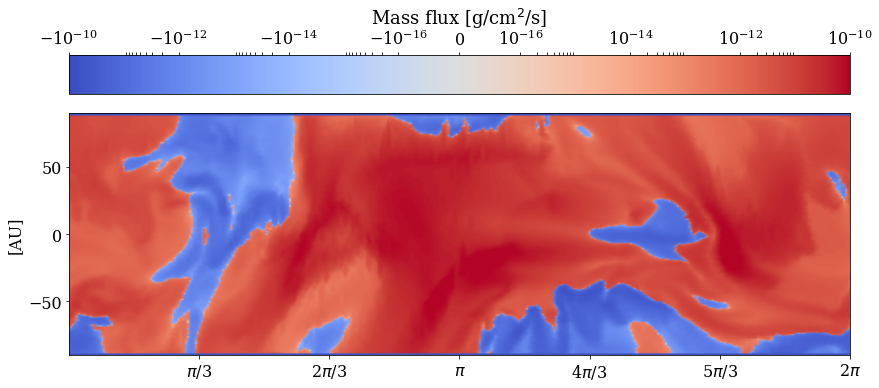

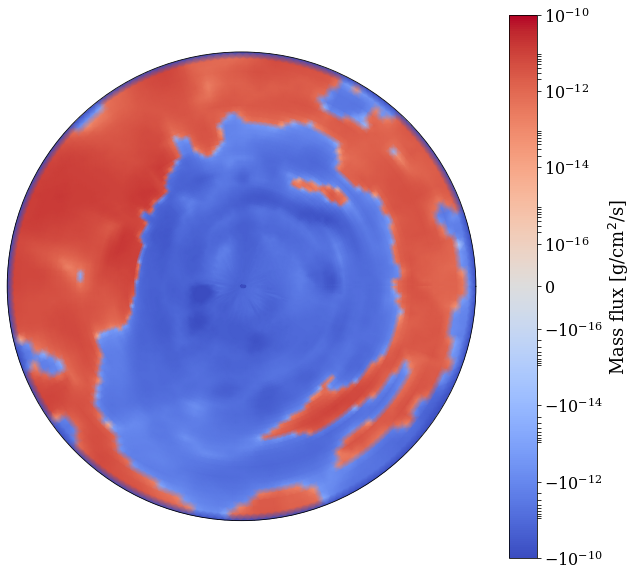

In [95]:
Mdot = data.massflux(radius=90, plot = True)

In [99]:
Mdot / data.sn.cgs.m_sun * data.sn.cgs.yr

array([ 4.02104721e-06, -6.94013554e-07])